In [12]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio as rio
from rasterio import features
from rasterio.windows import Window
import matplotlib.pyplot as plt
import numpy as np
import pprint as pp
import itertools as it
from tqdm import tqdm
import time


In [2]:
from rasterio.plot import show
from rasterio.warp import transform

xs = np.array([3327493.433, 16177493.43])
ys = np.array([7389201.61, -580798.392])

lossyear = 'data/Hansen_GFC-2022-v1.10_lossyear_50N_000E.tif'
datamask = 'data/Hansen_GFC-2022-v1.10_datamask_50N_000E.tif'
foo = 'data/TCL_DD_2022_20230407.tif'

src = rio.open(foo)
band = src.read(1)



In [3]:
mask = band != 12
shapes = features.shapes(band, mask=mask, transform=src.transform)
pp.pprint(next(shapes)) # first element
    

<class 'rasterio.io.DatasetReader'>
<class 'numpy.ndarray'>
({'coordinates': [[(1.4645000000000001, 50.0),
                   (1.4645000000000001, 49.99975),
                   (1.46525, 49.99975),
                   (1.46525, 49.9995),
                   (1.4655, 49.9995),
                   (1.4655, 50.0),
                   (1.4645000000000001, 50.0)]],
  'type': 'Polygon'},
 5.0)


({'coordinates': [[(1.4645000000000001, 50.0),
                   (1.4645000000000001, 49.99975),
                   (1.46525, 49.99975),
                   (1.46525, 49.9995),
                   (1.4655, 49.9995),
                   (1.4655, 50.0),
                   (1.4645000000000001, 50.0)]],
  'type': 'Polygon'},
 5.0)

In [97]:
# rasterio.features.dataset_features # works on raster value rather than mask...

with rio.open('data/TCL_DD_2022_20230407.tif') as src:
    # TODO: check src.count for number of bands...
    print(src.meta)
    band = src.read(1)
    mask = band == 1
    # Object holding a feature collection that implements the __geo_interface__
    # TODO: result should be in EPSG 4326 i.e. GPS
    results = (
        {'properties': {'deforestation': v}, 'geometry': s}
        for i, (s, v) in enumerate(
            features.shapes(band, mask=mask)
            )
        )
    geoms=list(results)
    gdf = gpd.GeoDataFrame.from_features(geoms)
    
gdf.head()


{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 15.0, 'width': 4008, 'height': 1737, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS_1984_Goode_Homolosine",GEOGCS["GCS_unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Interrupted_Goode_Homolosine"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(9999.999999999984, 0.0, -20037506.5671,
       0.0, -9999.999999999984, 8686794.97909997)}


,geometry,deforestation
0,"POLYGON ((2336.000 213.000, 2336.000 214.000, ...",1.0
1,"POLYGON ((2337.000 217.000, 2337.000 218.000, ...",1.0
2,"POLYGON ((514.000 223.000, 514.000 224.000, 51...",1.0
3,"POLYGON ((2339.000 224.000, 2339.000 225.000, ...",1.0
4,"POLYGON ((516.000 225.000, 516.000 226.000, 51...",1.0


geometry	deforestation
0	POLYGON ((2870.000 104.000, 2870.000 105.000, ...	4.0
1	POLYGON ((2777.000 110.000, 2777.000 111.000, ...	4.0
2	POLYGON ((2778.000 111.000, 2778.000 112.000, ...	4.0
3	POLYGON ((2730.000 113.000, 2730.000 114.000, ...	4.0
4	POLYGON ((2737.000 113.000, 2737.000 114.000, ...	4.0

In [116]:
# rasterio.features.dataset_features # works on raster value rather than mask...

with rio.open('data/Hansen_GFC-2022-v1.10_lossyear_20S_060W.tif') as src:
    # TODO: check src.count for number of bands...
    print(src.meta)
    band = src.read(1, window=Window(2100, 2000, 6000, 6000))
    #band = src.read(1)
    print(band.shape)
    rdf = gpd.GeoDataFrame()
    mask = band != 0
    # Object holding a feature collection that implements the __geo_interface__
    # TODO: result should be in EPSG 4326 i.e. GPS
    results = (
        {'properties': {'lossyear': v}, 'geometry': s}
        for i, (s, v) in enumerate(
            # connectivity, 4 on edges, 8 on edges and corners...
            features.shapes(band, mask=mask, connectivity=8)
            )
        )
    geoms=list(results)
    gdf = gpd.GeoDataFrame.from_features(geoms)
    rdf = gpd.GeoDataFrame( pd.concat( [rdf, gdf], ignore_index=True), crs=gdf.crs)

print(f'Chosen Window results in GeoDataFrame of .shape: {rdf.shape}')
rdf.head()


{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 40000, 'height': 40000, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00025, 0.0, -60.0,
       0.0, -0.00025, -20.0)}
(6000, 6000)
Chosen Window results in GeoDataFrame of .shape: (247166, 2)


,geometry,lossyear
0,"POLYGON ((0.000 0.000, 0.000 3.000, 4.000 3.00...",22.0
1,"POLYGON ((32.000 0.000, 32.000 3.000, 59.000 3...",22.0
2,"POLYGON ((85.000 0.000, 88.000 0.000, 88.000 2...",13.0
3,"POLYGON ((91.000 0.000, 91.000 1.000, 92.000 1...",22.0
4,"POLYGON ((151.000 0.000, 151.000 2.000, 159.00...",22.0


<Axes: >

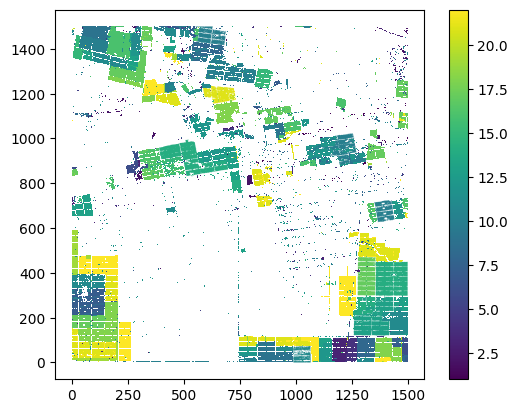

In [5]:
rdf.plot(column='lossyear', legend=True)

In [117]:
# sjoin does not modify the geometry...
intersects = rdf.sjoin(rdf, how="left", predicate="intersects")
intersects.shape, intersects.index.value_counts()

((598788, 4),
 221644    450
 135985    442
 132646    439
 127629    348
 32292     311
          ... 
 116820      1
 116821      1
 116822      1
 116823      1
 247165      1
 Name: count, Length: 247166, dtype: int64)

In [118]:
intersects.reset_index(inplace=True)
intersects.rename(columns={'index': 'index_left'}, inplace=True)
intersects.head()


,index_left,geometry,lossyear_left,index_right,lossyear_right
0,0,"POLYGON ((0.00000 0.00000, 0.00000 3.00000, 4....",22.0,0,22.0
1,1,"POLYGON ((32.00000 0.00000, 32.00000 3.00000, ...",22.0,100,2.0
2,1,"POLYGON ((32.00000 0.00000, 32.00000 3.00000, ...",22.0,1,22.0
3,1,"POLYGON ((32.00000 0.00000, 32.00000 3.00000, ...",22.0,146,4.0
4,1,"POLYGON ((32.00000 0.00000, 32.00000 3.00000, ...",22.0,179,10.0


In [119]:
# Nota bene: Robert Norris - this removes the self-intersection aggregates index_right, but
# also aggregates all other values into lists... it also spends far too much time in unary_union
# on geometry, the result of which we do not need.
#temp = intersects.dissolve("index_left", aggfunc=lambda x: x.tolist(),)

# Group by 'index_left', truncate intersects, then aggregate on 'index_right' only...
groups = intersects.groupby('index_left')
temp = intersects[intersects['index_left'] == intersects['index_right']].set_index('index_left')
temp['indices'] = groups['index_right'].aggregate(lambda x: x.tolist())
temp['indices'] = temp['indices'].apply(lambda x: np.sort(x))

temp.index.name = None
temp['lossyear'] = temp['lossyear_left'].astype("int") + 2000
temp.drop(['index_right', 'lossyear_left', 'lossyear_right'], axis=1, inplace=True)

temp.head()


,geometry,indices,lossyear
0,"POLYGON ((0.000 0.000, 0.000 3.000, 4.000 3.00...",[0],2022
1,"POLYGON ((32.000 0.000, 32.000 3.000, 59.000 3...","[1, 2, 100, 146, 179, 180, 181, 314]",2022
2,"POLYGON ((85.000 0.000, 88.000 0.000, 88.000 2...","[1, 2]",2013
3,"POLYGON ((91.000 0.000, 91.000 1.000, 92.000 1...","[3, 314]",2022
4,"POLYGON ((151.000 0.000, 151.000 2.000, 159.00...","[4, 101]",2022


In [120]:

group_id = 'group'

# See https://stackoverflow.com/questions/73566774/group-by-and-combine-intersecting-overlapping-geometries-in-geopandas
# This is not quite right... 5 should be part of the same group as 2, but since it was
# not previously encountered, a new group_id is taken that...
# we would need to take any of 'indices' that have previously been encountered...

'''
                 indices group
0                    [0]     0
1                    [1]     1
2                 [2, 3]     2
3           [2, 3, 4, 6]     2
4        [3, 4, 6, 7, 9]     2
5                 [5, 6]  None
6  [3, 4, 5, 6, 7, 8, 9]     2
                 indices group
0                    [0]     0
1                    [1]     1
2                 [2, 3]     2
3           [2, 3, 4, 6]     2
4        [3, 4, 6, 7, 9]     2
5                 [5, 6]     5
6  [3, 4, 5, 6, 7, 8, 9]     2
                 indices group
0                    [0]     0
1                    [1]     1
2                 [2, 3]     2
3           [2, 3, 4, 6]     2
4        [3, 4, 6, 7, 9]     2
5                 [5, 6]     5
6  [3, 4, 5, 6, 7, 8, 9]     5                 
'''

index_generator = range(len(temp))
start = time.time()
counter = it.count()

indices = temp['indices'].to_numpy()
groups = pd.Series([None] * len(temp))

for i, array in tqdm(zip(counter, indices), total=len(temp)):
    first_valid_index = groups.loc[array].first_valid_index()
    id = i if first_valid_index == None else groups.loc[first_valid_index]
    groups.loc[array] = id
end = time.time()
print(f'Loop over {len(temp)} took {end-start}s')

temp[group_id] = groups.copy()

# want to dissolve based on lossyear to generate any MULTIPOLYGON from disjoint geometry from same lossyear...
temp2 = temp.dissolve(
    [group_id, 'lossyear']
)
#temp.reset_index(inplace=True)
print(f'intersects.dissolve on group_id, lossyear in GeoDataFrame of .shape: {temp2.shape}')

temp2.head(30)
#temp['indices']




100%|██████████| 247166/247166 [03:08<00:00, 1311.37it/s]


Loop over 247166 took 188.55140900611877s
intersects.dissolve on group_id, lossyear in GeoDataFrame of .shape: (153765, 2)


geometry  \
group lossyear                                                      
0     2022      POLYGON ((0.000 0.000, 0.000 3.000, 4.000 3.00...   
1     2001      POLYGON ((44.000 35.000, 44.000 36.000, 45.000...   
      2002      MULTIPOLYGON (((59.000 2.000, 59.000 1.000, 57...   
      2003      MULTIPOLYGON (((73.000 43.000, 74.000 43.000, ...   
      2004      MULTIPOLYGON (((64.000 2.000, 64.000 3.000, 65...   
      2005      MULTIPOLYGON (((185.000 74.000, 186.000 74.000...   
      2006      MULTIPOLYGON (((205.000 162.000, 206.000 162.0...   
      2007      MULTIPOLYGON (((78.000 13.000, 78.000 14.000, ...   
      2008      MULTIPOLYGON (((84.000 25.000, 84.000 24.000, ...   
      2010      MULTIPOLYGON (((43.000 3.000, 43.000 4.000, 44...   
      2011      MULTIPOLYGON (((164.000 7.000, 164.000 6.000, ...   
      2012      MULTIPOLYGON (((71.000 16.000, 72.000 16.000, ...   
      2013      MULTIPOLYGON (((88.000 2.000, 88.000 0.000, 85...   
      2014      POLYGON ((206.000 341.000, 206.000 342.000, 20...   
      2017      POLYGON ((98.000 153.000, 102.000 153.000, 102...   
      2018      MULTIPOLYGON (((192.000 270.000, 191.000 270.0...   
      2019      MULTIPOLYGON (((79.000 8.000, 76.000 8.000, 76...   
      2020      POLYGON ((76.000 7.000, 76.000 8.000, 77.000 8...   
      2021      MULTIPOLYGON (((12.000 21.000, 7.000 21.000, 7...   
      2022      MULTIPOLYGON (((53.000 21.000, 53.000 20.000, ...   
4     2002      MULTIPOLYGON (((206.000 86.000, 206.000 83.000...   
      2004      POLYGON ((168.000 17.000, 168.000 18.000, 169....   
      2005      POLYGON ((207.000 35.000, 207.000 36.000, 208....   
      2006      MULTIPOLYGON (((75.000 163.000, 76.000 163.000...   
      2007      MULTIPOLYGON (((87.000 17.000, 87.000 16.000, ...   
      2010      MULTIPOLYGON (((54.000 5.000, 54.000 4.000, 52...   
      2011      MULTIPOLYGON (((187.000 6.000, 186.000 6.000, ...   
      2012      MULTIPOLYGON (((107.000 13.000, 107.000 14.000...   
      2013      MULTIPOLYGON (((85.000 14.000, 85.000 16.000, ...   
      2014      MULTIPOLYGON (((85.000 43.000, 85.000 44.000, ...   

                                                          indices  
group lossyear                                                     
0     2022                                                    [0]  
1     2001                                           [1482, 2115]  
      2002                                               [1, 100]  
      2003                                           [1695, 2115]  
      2004                                          [1, 146, 181]  
      2005                                           [2850, 3261]  
      2006                                    [6870, 7063, 11605]  
      2007                                             [586, 620]  
      2008                                      [995, 1032, 2115]  
      2010                                               [1, 179]  
      2011                                             [314, 315]  
      2012                                             [586, 683]  
      2013                                                 [1, 2]  
      2014                                         [15137, 15427]  
      2017      [6537, 6538, 6626, 6925, 6986, 7026, 7027, 702...  
      2018                                         [11604, 11697]  
      2019      [314, 408, 586, 595, 620, 683, 761, 798, 799, ...  
      2020                                        [314, 408, 586]  
      2021      [586, 956, 1177, 1271, 1272, 1316, 1317, 1318,...  
      2022                   [1, 2, 100, 146, 179, 180, 181, 314]  
4     2002                                     [3142, 3289, 3604]  
      2004                                            [762, 3604]  
      2005                                           [1492, 3604]  
      2006                                           [6924, 8843]  
      2007                                       [595, 730, 3604]  
      2010  

In [267]:
temp2.head()

geometry      indices
group lossyear                                                                
0     2022      POLYGON ((0.000 0.000, 0.000 3.000, 4.000 3.00...          [0]
1     2001      POLYGON ((44.000 35.000, 44.000 36.000, 45.000...   [310, 415]
      2002      MULTIPOLYGON (((59.000 2.000, 59.000 1.000, 57...      [1, 25]
      2003      MULTIPOLYGON (((73.000 43.000, 74.000 43.000, ...   [342, 415]
      2004      MULTIPOLYGON (((64.000 2.000, 64.000 3.000, 65...  [1, 40, 54]

In [121]:
group_ids = temp2.index.get_level_values(0).unique()
lossyears = range(2001, 2023)

#temp3 = temp2.set_index([group_id, 'lossyear'])
index = pd.MultiIndex.from_tuples(tuples=it.product(group_ids, lossyears), names=(group_id, 'lossyear'))
temp3 = temp2.reindex(index)

temp3.head(23)

geometry  \
group lossyear                                                      
0     2001                                                   None   
      2002                                                   None   
      2003                                                   None   
      2004                                                   None   
      2005                                                   None   
      2006                                                   None   
      2007                                                   None   
      2008                                                   None   
      2009                                                   None   
      2010                                                   None   
      2011                                                   None   
      2012                                                   None   
      2013                                                   None   
      2014                                                   None   
      2015                                                   None   
      2016                                                   None   
      2017                                                   None   
      2018                                                   None   
      2019                                                   None   
      2020                                                   None   
      2021                                                   None   
      2022      POLYGON ((0.00000 0.00000, 0.00000 3.00000, 4....   
1     2001      POLYGON ((44.00000 35.00000, 44.00000 36.00000...   

                     indices  
group lossyear                
0     2001               NaN  
      2002               NaN  
      2003               NaN  
      2004               NaN  
      2005               NaN  
      2006               NaN  
      2007               NaN  
      2008               NaN  
      2009               NaN  
      2010               NaN  
      2011               NaN  
      2012               NaN  
      2013               NaN  
      2014               NaN  
      2015               NaN  
      2016               NaN  
      2017               NaN  
      2018               NaN  
      2019               NaN  
      2020               NaN  
      2021               NaN  
      2022               [0]  
1     2001      [1482, 2115]

In [612]:
# Must be aware of chained indexing as it may call __get_item__ before __set_item__ which will fail on Nan/None etc.
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

#temp.index.names, temp.index.levels, temp.index.codes
#temp.isna() # shows only rows where at least one column value is set...
#temp.fillna(0)
#temp.loc[(1, 2018), 'geometry'] = None
#temp.loc[(1, 2017), 'index_right'] = 666
#temp.loc[:,].isnull().sum()
#temp.loc[temp.loc[:,].isna(), 'geometry']
#temp.geometry.fillna()
#temp.head()
#temp.loc[1,2019].geometry = None #shapely.geometry.Polygon([])


index_right       1
geometry          2
index_left        2
lossyear_left     2
lossyear_right    2
dtype: int64

In [126]:
temp3.loc[temp3['geometry'].isna(), 'geometry'] = Polygon([])
temp3['area'] = temp3.geometry.area
temp3['cum_area'] = temp3.groupby(group_id).area.cumsum()

for i in tqdm(group_ids.to_numpy()):
    temp3.loc[i, 'cum_geometry'] = list(it.accumulate(temp3.loc[i, 'geometry'], func=lambda x,y: x.union(y)))

temp3.reset_index(inplace=True)

temp3.drop(temp3[temp3.area == 0].index, inplace=True)

print(f'...and a final GeoDataFrame of .shape: {temp3.shape}')

temp3.to_csv('data/geoply-sample.csv')
temp3.head(30)

100%|██████████| 119367/119367 [05:29<00:00, 362.20it/s]


...and a final GeoDataFrame of .shape: (153765, 7)


,group,lossyear,geometry,indices,area,cum_area,cum_geometry
21,0,2022,"POLYGON ((0.000 0.000, 0.000 3.000, 4.000 3.00...",[0],62.0,62.0,"POLYGON ((0 0, 0 3, 4 3, 4 2, 29 2, 29 0, 0 0))"
22,1,2001,"POLYGON ((44.000 35.000, 44.000 36.000, 45.000...","[1482, 2115]",1.0,1.0,"POLYGON ((44 35, 44 36, 45 36, 45 35, 44 35))"
23,1,2002,"MULTIPOLYGON (((59.000 2.000, 59.000 1.000, 57...","[1, 100]",18.0,19.0,"MULTIPOLYGON (((44 36, 45 36, 45 35, 44 35, 44..."
24,1,2003,"MULTIPOLYGON (((73.000 43.000, 74.000 43.000, ...","[1695, 2115]",2.0,21.0,"MULTIPOLYGON (((45 36, 45 35, 44 35, 44 36, 45..."
25,1,2004,"MULTIPOLYGON (((64.000 2.000, 64.000 3.000, 65...","[1, 146, 181]",66.0,87.0,"MULTIPOLYGON (((45 35, 44 35, 44 36, 45 36, 45..."
26,1,2005,"MULTIPOLYGON (((185.000 74.000, 186.000 74.000...","[2850, 3261]",3.0,90.0,"MULTIPOLYGON (((44 35, 44 36, 45 36, 45 35, 44..."
27,1,2006,"MULTIPOLYGON (((205.000 162.000, 206.000 162.0...","[6870, 7063, 11605]",18.0,108.0,"MULTIPOLYGON (((44 36, 45 36, 45 35, 44 35, 44..."
28,1,2007,"MULTIPOLYGON (((78.000 13.000, 78.000 14.000, ...","[586, 620]",78.0,186.0,"MULTIPOLYGON (((45 36, 45 35, 44 35, 44 36, 45..."
29,1,2008,"MULTIPOLYGON (((84.000 25.000, 84.000 24.000, ...","[995, 1032, 2115]",37.0,223.0,"MULTIPOLYGON (((45 35, 44 35, 44 36, 45 36, 45..."
31,1,2010,"MULTIPOLYGON (((43.000 3.000, 43.000 4.000, 44...","[1, 179]",50.0,273.0,"MULTIPOLYGON (((44 35, 44 36, 45 36, 45 35, 44..."
